In [1]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
def binary_to_int(binary: list[bool]) -> int:
    assert len(binary) == 8

    return sum(int(x) * 2 ** (7 - i) for i, x in enumerate(binary))


class Individual:
    def __init__(self, x: int, y: int, bitstr: np.ndarray):
        assert len(bitstr) == 8
        self.x = x
        self.y = y
        self.bitstr = bitstr

    def cross(
        self, other: "Individual", pos: np.ndarray
    ) -> tuple["Individual", "Individual"]:
        if pos == -1:
            return self, other
        assert pos >= 0 and pos < 8

        ind1 = self.bitstr.copy()
        ind2 = other.bitstr.copy()

        ind1[pos:] = other.bitstr[pos:]
        ind2[pos:] = self.bitstr[pos:]

        return (Individual(self.x, self.y, ind1), Individual(other.x, other.y, ind2))

    def mutate(self, mutations: np.ndarray):
        assert len(mutations) == 8
        self.bitstr[mutations] = np.invert(self.bitstr[mutations])

In [3]:
a, b = 0.9, 0.1
r = 1


def get_neighborhood(x, y, img: np.ndarray) -> np.ndarray:
    vals = []
    h, w = img.shape[0], img.shape[1]
    for i in range(max(x - r, 0), min(x + r + 1, h)):
        for j in range(max(y - r, 0), min(y + r + 1, w)):
            if i == x and j == y:
                continue
            vals.append(img[i, j])

    return np.array(vals)


def rho(x: int, y: int, gy: np.ndarray, img: np.ndarray) -> float:
    d1 = np.abs(img[x, y] - gy) / np.vstack([img[x, y], gy]).max(axis=0)
    neighbors = get_neighborhood(x, y, img)
    d2 = sum(np.abs(n - gy) / np.vstack([n, gy]).max(axis=0) for n in neighbors)

    return (a * d1 + b * d2).mean()

def get_clusters(population):
    clusters = {}
    for p in population:
        cluster = binary_to_int(p.bitstr)
        if cluster in clusters:
            clusters[cluster].append((p.x, p.y))
        else:
            clusters[cluster] = [(p.x, p.y)]

    return clusters



def fitness(ind: Individual, population: list[Individual], img: np.ndarray, clusters: dict) -> float:
    mvj = np.array([img[x, y] for x, y in clusters[binary_to_int(ind.bitstr)]]).mean(axis=0)

    result = rho(ind.x, ind.y, mvj, img)

    return result


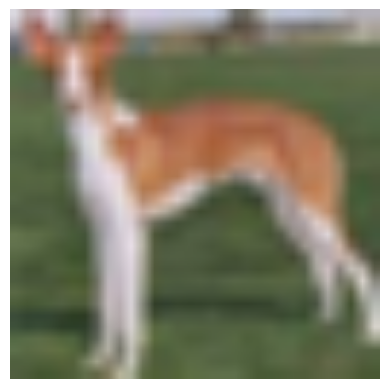

In [4]:
img = cv.imread('./data/cifar-dog.png', cv.IMREAD_COLOR)
img = cv.resize(img, (244, 244), interpolation= cv.INTER_LINEAR)
img = cv.cvtColor(img, cv.COLOR_BGR2RGB)

plt.imshow(img)
plt.axis('off')
plt.show()

In [5]:
p_c = .8
p_m = .01

sample_from = [-1] + list(range(0, 8))
probs = [1 - p_c] + [p_c / 8] * 8

population = []
data = np.random.choice([True, False], (img.shape[0] * img.shape[1], 8))

for k in range(img.shape[0] * img.shape[1]):
    population.append(Individual(k//img.shape[0], k%img.shape[0], data[k]))

In [6]:
N = len(population)
for iter in tqdm(range(500)):
    new_population = {}
    pos = np.random.choice(sample_from, size=(N // 2), p=probs)
    mutations = np.random.choice([True, False], size=(N // 2, 2, 8), p=[p_m, 1 - p_m])
    for i in range(N // 2):
        child1, child2 = population[i].cross(population[N - 1 - i], pos[i])
        child1.mutate(mutations[i, 0])
        child2.mutate(mutations[i, 1])

        new_population[i] = child1
        new_population[N - 1 - i] = child2

    clusters = get_clusters(population)
    new_clusters = get_clusters([new_population[key] for key in range(N)])
    final_population = [
        (
            new_population[i]
            if fitness(new_population[i], new_population, img, new_clusters)
            < fitness(population[i], population, img, clusters)
            else population[i]
        )
        for i in range(N)
    ]

    population = final_population

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [01:06<?, ?it/s]


KeyboardInterrupt: 

C:\Users\Admin\AppData\Local\Temp\ipykernel_1580\760711799.py:1: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  plt.imshow(np.array([binary_to_int(x.bitstr) for x in population]).reshape(244, 244), cmap=plt.cm.get_cmap('tab20', 10))


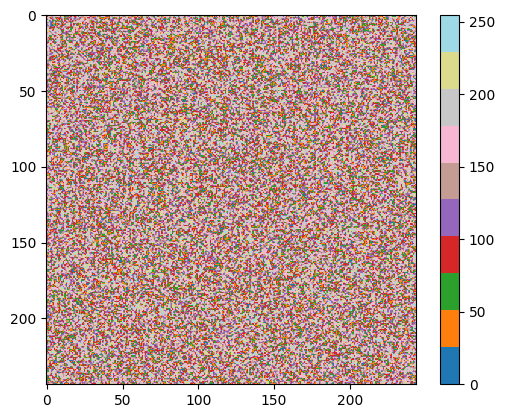

In [ ]:
plt.imshow(np.array([binary_to_int(x.bitstr) for x in population]).reshape(32, 32), cmap=plt.cm.get_cmap('tab20', 10))
plt.colorbar()

In [ ]:
N = len(population)
for iter in tqdm(range(1)):
    gamma_population = {}
    for ind in population:
        gamma_population[(ind.x, ind.y)] = [ind]
    pos = np.random.choice(sample_from, size=(len(population), len(population)), p=probs)
    mutations = np.random.choice([True , False], size=(len(population), len(population), 2, 8), p=[p_m, 1-p_m])
    for i in range(len(population)):
        for j in range(i+1, len(population)):
            child1, child2 = population[i].cross(population[j], pos[i,j])
            child1.mutate(mutations[i,j,0])
            child2.mutate(mutations[i,j,1])

            gamma_population[(child1.x, child1.y)].append(child1)
            gamma_population[(child2.x, child2.y)].append(child2)

100%|██████████| 1/1 [00:05<00:00,  5.23s/it]
